In [4]:
# Import Necessary Modules

import glob
import matplotlib.pyplot as plt 
from skimage import io
import numpy as np

import seaborn as sns
import pandas as pd

from sklearn import decomposition
from sklearn.datasets import make_blobs

from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, GaussianNoise, Conv1D
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline 

Using TensorFlow backend.


In [5]:
#This function reads in all n images in catsfolder/ and dogsfolder/. 
#Each 64 x 64 image is reshaped into a length-4096 row vector. 
#These row vectors are stacked on top of one another to get a data matrix
#X of size n x 4096. We also generate a -1 label if the row vector corresponds
#to a cat image and a +1 label if the row vector corresponds to a dog image
#and stack these on top of one another to get a label vector y of length n.

def read_data():
    
    #get image filenames
    cat_locs = glob.glob('./pet_classification_dataset/pet_classification_dataset/catsfolder/*.jpg')
    dog_locs = glob.glob('./pet_classification_dataset/pet_classification_dataset/dogsfolder/*.jpg')
    num_cats = len(cat_locs)
    num_dogs = len(dog_locs)

    #initialize empty arrays
    X_cats = np.zeros((num_cats,64*64))
    X_dogs = np.zeros((num_dogs,64*64))
    y_cats = np.zeros((num_cats,1))
    y_dogs = np.zeros((num_dogs,1))
               
    #Load data, reshape into a 1D vector and set labels
    
    keep_track = 0

    for i in range(len(cat_locs)):
        img = cat_locs[i]
        im = io.imread(img)
        im = im.reshape(64*64)
        X_cats[i,:] = im
        y_cats[i] = -1.0
        keep_track += 1

    for i in range(len(dog_locs)):
        img = dog_locs[i]
        im = io.imread(img)
        im = im.reshape(64*64)
        X_dogs[i,:] = im
        y_dogs[i] = 1.0
        keep_track += 1
    
    # combine both datasets
    X = np.append(X_cats,X_dogs,0)
    y = np.append(y_cats,y_dogs)
    
    return X, y 

In [7]:
#This function takes in an n x 4096 data matrix X and an index i. It extracts
#the ith row of X and displays it as a grayscale 64 x 64 image.

def show_image(X, i):
    #select image
    image = X[i,:]
    #reshape make into a square
    image = image.reshape((64,64))
    #display the image
    plt.imshow(image,'gray')

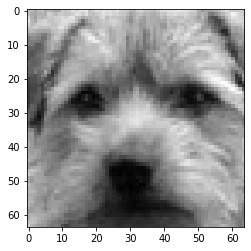

In [8]:
#Test to see if read_data and show_image working
X,y = read_data()
show_image(X,1400)

In [9]:
#This function takes in a vector of true labels ytrue
#and a vector of guessed labels yguess and reports back
#the accuracy of the guesses out of 100%.

def calculate_accuracy(ytrue, yguess):
    
    # compare your predictions with the correct labels to determine how many of your predictions were correct.
    correct = sum((ytrue == yguess))
    total = len(ytrue)
    accuracy = 100*float(correct)/float(total)
    # divide the number of correct predictions by the number of total samples to determine your classification accuracy.
    return accuracy

In [10]:
#This function takes in a data matrix X, label vector y, and 
#the desired percentage testpercent. It randomly assigns  
#testpercent of the rows of X and y to Xtest and ytest. 
#The remaining data is assigned to Xtrain and ytrain.

def split_data(X,y,testpercent):
        
    [n, d] = X.shape
    
    ntest = int(round(n*(float(testpercent)/100)))
    ntrain = int(round(n - ntest))
        
    Xtrain = np.zeros((ntrain,d))
    Xtest = np.zeros((ntest,d))
    ytrain = np.zeros((ntrain,1))
    ytest = np.zeros((ntest,1))   
        
    Data = np.column_stack((X,y))
    Data = np.random.permutation(Data)
    
    for i in range(ntest):
        Xtest[i,:] = Data[i,0:d]
        ytest[i] = Data[i,d]
        
    for i in range(ntrain):
        Xtrain[i,:] = Data[i+ntest,0:d]
        ytrain[i] = Data[i+ntest,d]
        
    return Xtrain, ytrain, Xtest, ytest

In [11]:
#This function takes in a data matrix X and a label
#vector y and outputs the average cat image and average dog image.

def average_pet(X,y):
    
    avgcat, avgdog = np.zeros((1,4096)), np.zeros((1,4096))
    #average cat image, where cats are index 0-999
    catct, dogct = 0,0

    #for all image matrices and tags in X,
    for observation, label in zip(X, y):
        if label == 1: # if dog tag,
            avgdog += observation # stack the pixel matrices
            dogct += 1 # store ct of dog image matrices
        elif label == -1: # if cat tag,
            avgcat += observation # stack the pixel matrices
            catct += 1 # store ct of cat image matrices
    avgdog = np.divide(avgdog, dogct) # average the stacked image
    avgcat = np.divide(avgcat, catct) # average the stacked image
    
    print('**Cat Images Averaged.**')

    print('**Dog Images Averaged.**')
        
    return avgcat, avgdog

**Cat Images Averaged.**
**Dog Images Averaged.**
<< Average Cat Image, Average Dog Image >>


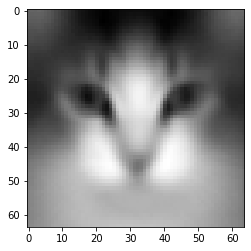

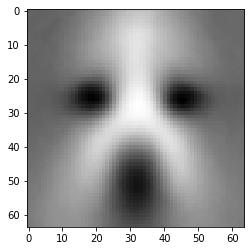

In [12]:
# calculate the average dog & cat by stacking + averaging a vector of image matrices
avgcat, avgdog = average_pet(X,y)

print('<< Average Cat Image, Average Dog Image >>')
#display the average cat
show_image(avgcat,0)

# display the average dog
fig = plt.figure()
show_image(avgdog,0)

#print('<< Average Dog Image >>')
#display the average dog
#plt.imshow(avgdog,'gray')

In [13]:
#This function takes in a training data matrix Xtrain, training
#label vector ytrain and uses them to compute the average cat
#and dog vectors. It also takes in a data matrix Xrun and 
#produces a vector of label guesses yguess, corresponding to whether
#each row of Xtest is closer to the average cat or average dog.

def closest_average(Xtrain,ytrain,Xrun):
    
    yguess = np.zeros((len(Xrun), 1))
    avgcat = np.zeros(4096)
    avgdog = np.zeros(4096)
    
    catct = 0
    dogct = 0
    # for all matrices and tags in Xtrain,
    for observation, label in zip(Xtrain,ytrain):
        if label == 1:
            avgdog += observation # stack img matrix
            dogct += 1
        elif label == -1:
            avgcat += observation # stack img matrix
            catct += 1
    avgdog = np.divide(avgdog,dogct) # average the stacked matrix
    avgcat = np.divide(avgcat, catct) # average the stacked matrix

        # for all matrices and tags in Xrun
    for index, observation in enumerate(Xrun):
        if np.linalg.norm(observation - avgcat) <= np.linalg.norm(observation - avgdog): # if the present matrix is closer to an avg cat
            yguess[index] = -1
        elif np.linalg.norm(observation - avgcat) > np.linalg.norm(observation - avgdog): # if the present matrix is closer to an avg dog
            yguess[index] = 1

    #yguess = [None] * 400
    #yguess = 0
    
    #make a vector of labels yguess for elem 0-399 in Xrun (Xtest)
    #for step in range(0,400):
     #   yguess[step] = 0
        # find the true case labels of x test for the closest avge
      #  distcat = np.subtract(Xrun[step,:],avgcat)
       # distcat = np.sqrt(distcat**2) 
       # print('Distance from the average cat?')
       # print(distcat)
        
        # find the true case labels of x test for the closest avg
       # distdog = np.subtract(Xrun[step,:],avgdog)
       # distdog = np.sqrt(distdog**2) 
       # print('Distance from the average dog?')
       # print(distdog)

        #if distcat[step] <= distdog[step]:
            #false labels of ylabel
            #print('neg')
         #   yguess[step] -= 1
            #print(yguess[step])
     #   elif distcat[step] > distdog[step]:
            #true labels of ylabel
            #print('pos')
    #        yguess[step] += 1
            #print(yguess[step])

    return yguess

In [14]:
# vector of image matrices split into 20% testing data, 80% training data
Xtrain, ytrain, Xtest, ytest = split_data(X,y,20)
print('** data split into 20% testing data and 80% training data **')

yguess=closest_average(Xtrain,ytrain,Xtest)
yguess_train=closest_average(Xtrain,ytrain,Xtrain)
print('By closest average classifier')
print("Training Accuracy --",calculate_accuracy(ytrain, yguess_train))
print("Test Accuracy --",calculate_accuracy(ytest, yguess))

** data split into 20% testing data and 80% training data **
By closest average classifier
Training Accuracy -- 80.6875
Test Accuracy -- 79.5


In [15]:
#This function takes in a training data matrix Xtrain, training
#label vector ytrain and uses them to compute the average cat
#and dog vectors. It also takes in a data matrix Xrun and 
#produces a vector of label guesses yguess. Each guess is found
#by searching through Xtrain to find the closest row, and then 
#outputting its label.

def nearest_neighbor(Xtrain,ytrain,Xrun):
    yguess = np.zeros((len(Xrun), 1))

    # for all matrices and tags in Xrun
    for i, testdata in enumerate(Xrun):
        distance = 500000000000 # arbitrarily large number
        for observation, label in zip(Xtrain, ytrain):
            if i == 0: # if first element
                distance = np.linalg.norm(testdata - observation)
            elif np.linalg.norm(testdata - observation) < distance: # if a new smallest is found,
                yguess[i] = label # store its type
                distance = np.linalg.norm(testdata - observation) # recalculate distance

    #for i in range(0,400):
     #   for j in range(0,1599):
      #      temp = Xrun[i,:] - Xtrain[j,:]
       #     check = Xrun[i,:] - Xtrain[j+1,:]
        #    if temp[i] <= check[i]:
         #       yguess = ytrain[j]
          #  elif temp[i] > check[i]:
           #     yguess = ytrain[j+1]
    
    return yguess

In [18]:
#given image matrices in Xtrain, find the closest match in other matrix set

yguess=nearest_neighbor(Xtrain,ytrain,Xtest)
yguess_train=nearest_neighbor(Xtrain,ytrain,Xtrain)
print('By nearest neighbor classifier')
print("Training Accuracy --",calculate_accuracy(ytrain, yguess_train))
print("Test Accuracy --",calculate_accuracy(ytest, yguess))

By nearest neighbor classifier
Training Accuracy -- 99.9375
Test Accuracy -- 85.25


In [19]:
#This function takes in a training data matrix Xtrain, training
#label vector ytrain and uses them to compute ordinary-least-squares
#vector b. It also takes in a data matrix Xrun and 
#produces a vector of label guesses yguess, corresponding to the sign
#of the linear prediction.

def linear_regression(Xtrain,ytrain,Xrun):
    
    #bols = (np.linalg.pinv(np.linalg.pinv(Xtrain) * Xtrain)) * np.linalg.pinv(Xtrain) * ytrain

    #hlinear = sign(np.linalg.pinv(Xtrain) * bols)

    #if hlinear <= 0:
        #yguess[i] = -1
    #elif hlinear > 0:
        #yguess[i] = 1
    

    b_ols=np.matmul(np.matmul(np.linalg.pinv(np.matmul(np.transpose(Xtrain), Xtrain)),np.transpose(Xtrain)),ytrain) # ordinary least squares coefficient
    yguess=np.sign(np.matmul(Xrun,b_ols)) # linear classifier, +1 if outcome is positive, -1 otherwise
    return yguess

In [20]:
yguess=linear_regression(Xtrain,ytrain,Xtest)
yguess_train=linear_regression(Xtrain,ytrain,Xtrain)
print('By linear regression')
print('Training Accuracy --',calculate_accuracy(ytrain, yguess_train))
print('Test Accuracy --',calculate_accuracy(ytest, yguess))

By linear regression
Training Accuracy -- 100.0
Test Accuracy -- 80.0


In [21]:

yguess=closest_average(Xtrain,ytrain,Xtest)
yguess_train=closest_average(Xtrain,ytrain,Xtrain)
print('By closest average classifier')
print("Training Accuracy --",calculate_accuracy(ytrain, yguess_train))
print("Test Accuracy --",calculate_accuracy(ytest, yguess))

By closest average classifier
Training Accuracy -- 80.6875
Test Accuracy -- 79.5


In [22]:
#This code implements the PCA exactly as in MATLAB so as to be consistent.
#It takes in an n x d data matrix X and returns a d x d orthonormal matrix pcaX. 
#Each column of pcaX contains a basis vector, sorted by decreasing variance.

def pca(X):
    covX = np.cov(X,rowvar=False)
    [Lambda,Vtranspose] = np.linalg.eig(covX)
    neworder = np.argsort(-abs(Lambda))
    pcaX = Vtranspose[:,neworder]
    pcaX = pcaX.real
    return pcaX

(100, 10)
PC1,PC2...,PCA for all A in descending order of variance --  [0.41594854 0.3391866  0.1600729  0.02016822]


Text(0, 0.5, 'Cumulative explained variance')

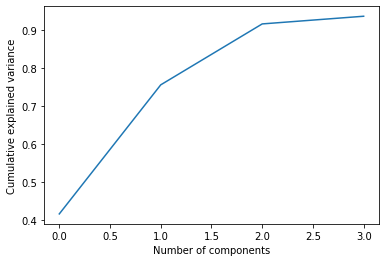

In [27]:
#pca_xtrain=pca(Xtrain)
X1, Y1 = make_blobs(n_features=10, 
         n_samples=100,
         centers=4, random_state=4, # 100 samples x 10 observations
         cluster_std=2)
print(X1.shape)

pca = decomposition.PCA(n_components=4) # set the number of principal components

pc = pca.fit_transform(X1)

pca_std = np.std(pc)

# state the axis k which limits the size of the pca variance
pc_df = pd.DataFrame(data = pc , 
        columns = ['PC1', 'PC2','PC3','PC4'])
pc_df['Cluster'] = Y1
pc_df.head()

print("PC1,PC2...,PCA for all A in descending order of variance -- ", pca.explained_variance_ratio_)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
#df = pd.DataFrame({'var':pca.explained_variance_ratio_,
          #   'PC':['PC1','PC2','PC3','PC4']})
#sns.barplot(x='PC',y="var", 
    #       data=df, color="c");

#fig=plt.figure()
#for i in range(0,10):
 #   fig.add_subplot(2,5,i+1)
  #  show_image(np.transpose(pca_xtrain),i)
# 10 eigenvectors which are 'averaged' over the data with most variance, in order of decreasing variance

PC1 explains 41.59485 % variance of the data
PC2 explains 33.91866 % variance of the data
We are depicting 75.51351 % of the data
Horizontality (PC1) is more relevant in explaining the data's distribution than Verticality (PC2)
PC1 is 1.22631 times the size of PC2


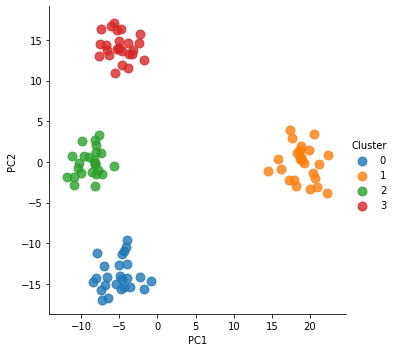

In [93]:
sns.lmplot( x="PC1", y="PC2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

print("PC1 explains", np.around(pca.explained_variance_ratio_[0] * 100, decimals=5,out=None), "% variance of the data")
print("PC2 explains", np.around(pca.explained_variance_ratio_[1] * 100,decimals=5,out=None), "% variance of the data")
print("We are depicting",np.around(100*(pca.explained_variance_ratio_[0]+ pca.explained_variance_ratio_[1]),decimals=5,out=None),"% of the data")

if pca.explained_variance_ratio_[0] > pca.explained_variance_ratio_[1]:
    print("Horizontality (PC1) is more relevant in explaining the data's distribution than Verticality (PC2)")
    print("PC1 is", np.around(pca.explained_variance_ratio_[0]/ pca.explained_variance_ratio_[1],decimals=5,out=None), "times the size of PC2" )
elif pca.explained_variance_ratio_[0] < pca.explained_variance_ratio_[1]:
    print("Verticality (PC2) is more relevant in explaining the data's distribution than Horizontality (PC1)")
    print("PC2 is", np.around(pca.explained_variance_ratio_[1]/ pca.explained_variance_ratio_[0],decimals=5,out=None), "times the size of PC1" )

In [113]:
model = Sequential()
layers = 1
units = 128

model.add(Dense(units, input_dim=4, activation='relu'))
model.add(GaussianNoise(pca_std))
for i in range(layers):
    model.add(Dense(units, activation='relu'))
    model.add(GaussianNoise(pca_std))
    model.add(Dropout(0.1))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['categorical_accuracy'])

model.fit(pc, ytrain, epochs=100, batch_size=256, validation_split=0.15, verbose=2)

NameError: name 'pca_std' is not defined

In [25]:
#This function takes in a training data matrix Xtrain, training
#label vector ytrain and uses them to compute the PCA basis. 
#It also takes in a data matrix Xrun and a dimension k
#and uses the top-k vectors in the PCA basis to reduce the 
#dimension of Xtrain and Xrun. Finally, it uses the reduced data
#as inputs to the linear_regression function to produce 
#a vector of label guesses yguess.

def pca_regression(Xtrain,ytrain,Xrun,k):
    
    X=np.concatenate((Xtrain, Xrun), axis=0)
    # boil down Xtrain so we may easier guess its matches
    Xtrain_reduced=pca(X.T)[0:len(Xtrain),0:k]
    # boil down Xrun so we may easier guess its matches
    Xrun_reduced=pca(X.T)[len(Xtrain):,0:k]
    yguess=linear_regression(Xtrain_reduced,ytrain,Xrun_reduced)
    return yguess

In [26]:

print('Dimensions -- k=1000')
yguess=pca_regression(Xtrain,ytrain,Xtest,1000)
yguess_train=pca_regression(Xtrain,ytrain,Xtrain,1000)
print('Training Accuracy --',calculate_accuracy(ytrain, yguess_train))
print('Test Accuracy --',calculate_accuracy(ytest, yguess))

Dimensions -- k=1000
Training Accuracy -- 99.25
Test Accuracy -- 79.75
